In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import wilcoxon, shapiro
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_iphone = pd.read_pickle('/content/drive/MyDrive/Arlette/Dataframes Machine Learning/df_ml.pkl')

In [4]:
df_iphone.head()

,File Name clean,Genus,LABEL,processed_image,x1,x2,x3,x4,x5,x6,...,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18
0,001l_Culex_pipiens_Test,Culex,Culex pipiens,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.350000,0.665625,0.948438,0.970313,0.976562,0.967187,...,0.703125,0.765625,0.571875,0.550000,0.509375,0.506250,0.47500,0.446875,0.425000,0.550000
1,002r_Culex_pipiens_Test,Culex,Culex pipiens,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.353125,0.681250,0.946875,0.965625,0.975000,0.973437,...,0.618750,0.681250,0.471875,0.450000,0.409375,0.406250,0.37500,0.337500,0.325000,0.456250
2,003l_Culex_pipiens_Test,Culex,Culex pipiens,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.326562,0.626563,0.931250,0.950000,0.956250,0.950000,...,0.671875,0.721875,0.496875,0.500000,0.450000,0.453125,0.41875,0.384375,0.365625,0.509375
3,005l_Culex_pipiens_Test,Culex,Culex pipiens,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.334375,0.620313,0.931250,0.956250,0.960938,0.956250,...,0.643750,0.706250,0.509375,0.490625,0.443750,0.443750,0.40625,0.368750,0.356250,0.493750
4,005r_Culex_pipiens_Test,Culex,Culex pipiens,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.339062,0.632812,0.948438,0.970313,0.975000,0.967187,...,0.656250,0.709375,0.493750,0.478125,0.431250,0.440625,0.39375,0.359375,0.337500,0.481250


In [5]:
images = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_images_160x320.npy')
true_landmarks = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')

CNN_full_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation.npy')
UNET_full_augmenatation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation.npy')

In [6]:
idx_test= np.load('/content/drive/MyDrive/Arlette/idx_test.npy')

In [7]:
len(idx_test)

987

In [8]:
true_landmarks.shape

(987, 18, 2)

get genus and species for samples

In [9]:
y_test_genera  = df_iphone.loc[idx_test, "Genus"].values
y_test_species = df_iphone.loc[idx_test, "LABEL"].values

In [10]:
unique_genera = np.unique(y_test_genera)
print("Genera in test-set:", unique_genera)
print("count of differnet genera:", len(unique_genera))

Genera in test-set: ['Aedes' 'Anopheles' 'Armigeres' 'Coquillettidia' 'Culex' 'Culiseta'
 'Mansonia' 'Tripteroides']
count of differnet genera: 8


PCA CNN

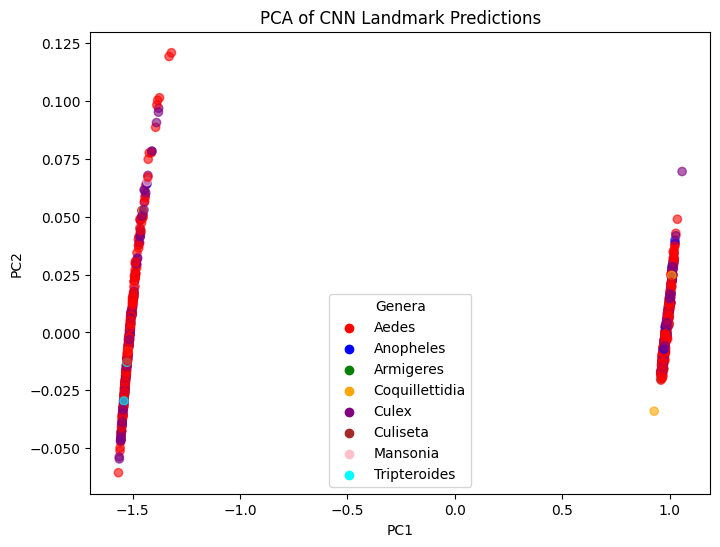

In [12]:
#label encoder (to numbers)
le = LabelEncoder()
y_numeric = le.fit_transform(y_test_genera)

# colors
colors_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']

# genera to color
color_dict = {genus: colors_list[i] for i, genus in enumerate(le.classes_)}

# num labels to color
point_colors = [color_dict[genus] for genus in y_test_genera]

# PCA Landmarks
X = CNN_full_augmentation.reshape(CNN_full_augmentation.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=point_colors, alpha=0.6)

# legend
for genus, color in color_dict.items():
    plt.scatter([], [], color=color, label=genus)
plt.legend(title="Genera")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of CNN Landmark Predictions")
plt.show()


PCA CNN left/ right

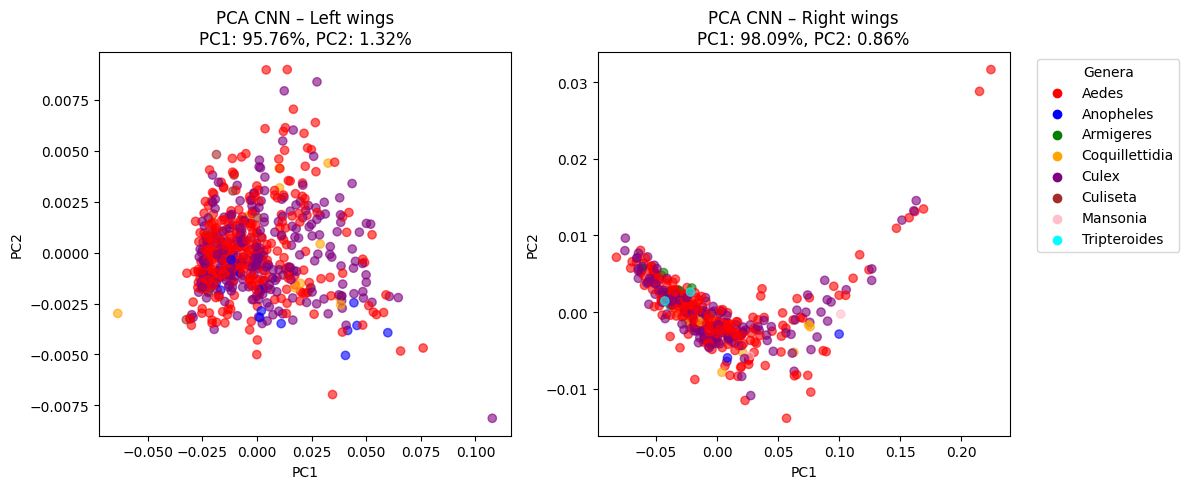

In [42]:
# cnn
X_landmarks_CNN = CNN_full_augmentation

# orientation
orientation = np.array([
    "right" if lm[0,0] > lm[9,0] else "left"
    for lm in X_landmarks_CNN])

left_idx = (orientation == "left")
right_idx = (orientation == "right")

# PCA left
X_left = X_landmarks_CNN[left_idx].reshape(sum(left_idx), -1)
pca_left = PCA(n_components=2)
X_pca_left = pca_left.fit_transform(X_left)
pc1_var_left = pca_left.explained_variance_ratio_[0] * 100
pc2_var_left = pca_left.explained_variance_ratio_[1] * 100

# PCA right
X_right = X_landmarks_CNN[right_idx].reshape(sum(right_idx), -1)
pca_right = PCA(n_components=2)
X_pca_right = pca_right.fit_transform(X_right)
pc1_var_right = pca_right.explained_variance_ratio_[0] * 100
pc2_var_right = pca_right.explained_variance_ratio_[1] * 100

# plot
plt.figure(figsize=(12,5))

# Left wings
plt.subplot(1,2,1)
plt.scatter(X_pca_left[:,0], X_pca_left[:,1],
            c=[color_dict[g] for g in y_test_genera[left_idx]], alpha=0.6)
plt.title(f"PCA CNN – Left wings\nPC1: {pc1_var_left:.2f}%, PC2: {pc2_var_left:.2f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")

# Right wings
plt.subplot(1,2,2)
plt.scatter(X_pca_right[:,0], X_pca_right[:,1],
            c=[color_dict[g] for g in y_test_genera[right_idx]], alpha=0.6)
plt.title(f"PCA CNN – Right wings\nPC1: {pc1_var_right:.2f}%, PC2: {pc2_var_right:.2f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")

# legend (shared)
for genus, color in color_dict.items():
    plt.scatter([], [], color=color, label=genus)
plt.legend(title="Genera", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

PCA UNet

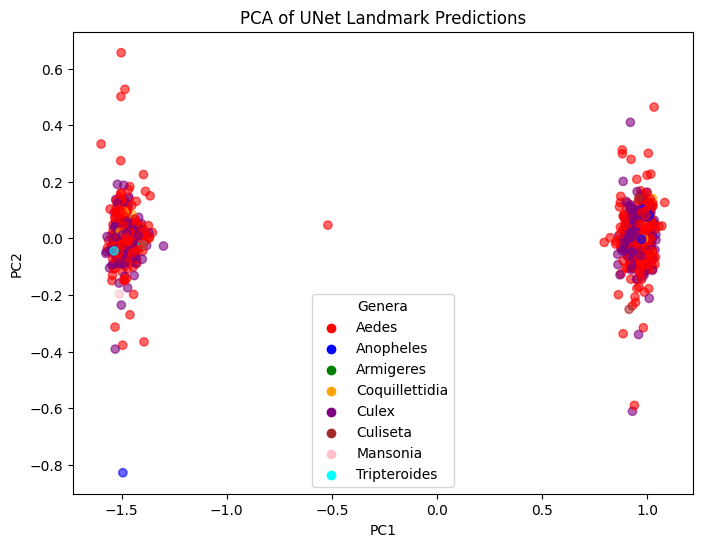

In [15]:
#label encoder (to numbers)
le = LabelEncoder()
y_numeric = le.fit_transform(y_test_genera)

# colors
colors_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']

# genera to color
color_dict = {genus: colors_list[i] for i, genus in enumerate(le.classes_)}

# num labels
point_colors = [color_dict[genus] for genus in y_test_genera]

# PCA
X = UNET_full_augmenatation.reshape(UNET_full_augmenatation.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=point_colors, alpha=0.6)

# legend
for genus, color in color_dict.items():
    plt.scatter([], [], color=color, label=genus)
plt.legend(title="Genera")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of UNet Landmark Predictions")
plt.show()

PCA UNet left/ right

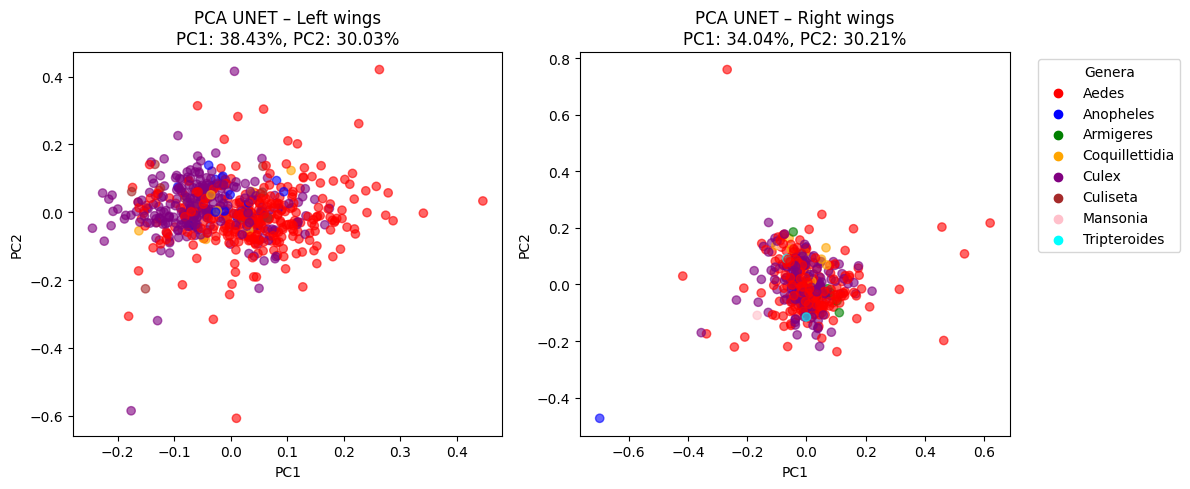

In [43]:
left_idx = (orientation == "left")
right_idx = (orientation == "right")

X_landmarks_UNET = UNET_full_augmenatation

# PCA left
X_left = X_landmarks_UNET[left_idx].reshape(sum(left_idx), -1)
pca_left = PCA(n_components=2)
X_pca_left = pca_left.fit_transform(X_left)
pc1_var_left = pca_left.explained_variance_ratio_[0] * 100
pc2_var_left = pca_left.explained_variance_ratio_[1] * 100

# pca right
X_right = X_landmarks_UNET[right_idx].reshape(sum(right_idx), -1)
pca_right = PCA(n_components=2)
X_pca_right = pca_right.fit_transform(X_right)
pc1_var_right = pca_right.explained_variance_ratio_[0] * 100
pc2_var_right = pca_right.explained_variance_ratio_[1] * 100

# plot
plt.figure(figsize=(12,5))

# left
plt.subplot(1,2,1)
plt.scatter(X_pca_left[:,0], X_pca_left[:,1],
            c=[color_dict[g] for g in np.array(y_test_genera)[left_idx]],
            alpha=0.6)
plt.title(f"PCA UNET – Left wings\nPC1: {pc1_var_left:.2f}%, PC2: {pc2_var_left:.2f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")

# right
plt.subplot(1,2,2)
plt.scatter(X_pca_right[:,0], X_pca_right[:,1],
            c=[color_dict[g] for g in np.array(y_test_genera)[right_idx]],
            alpha=0.6)
plt.title(f"PCA UNET – Right wings\nPC1: {pc1_var_right:.2f}%, PC2: {pc2_var_right:.2f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")

# legend (shared)
for genus, color in color_dict.items():
    plt.scatter([], [], color=color, label=genus)
plt.legend(title="Genera", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

CNN PCA unicolor

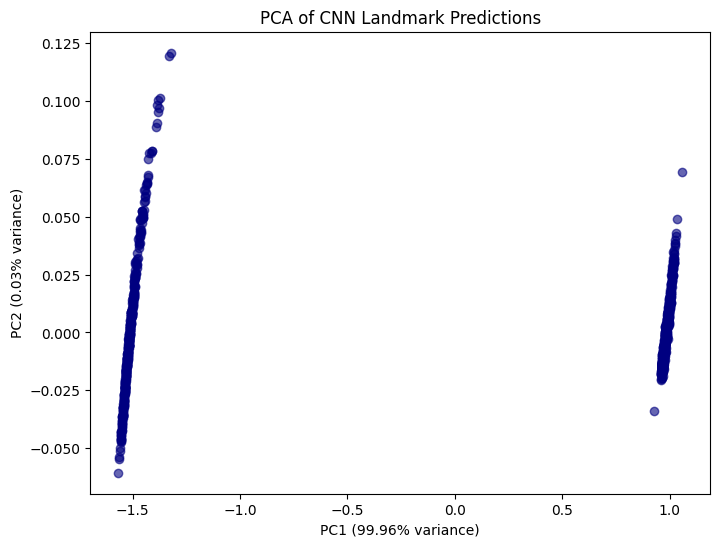

In [44]:
# PCA
X = CNN_full_augmentation.reshape(CNN_full_augmentation.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# get variance
var_ratio = pca.explained_variance_ratio_
pc1_var = var_ratio[0] * 100
pc2_var = var_ratio[1] * 100

# plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c="navy", alpha=0.6)

plt.xlabel(f"PC1 ({pc1_var:.2f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.2f}% variance)")
plt.title("PCA of CNN Landmark Predictions")
plt.show()

PCA UNet unicolor

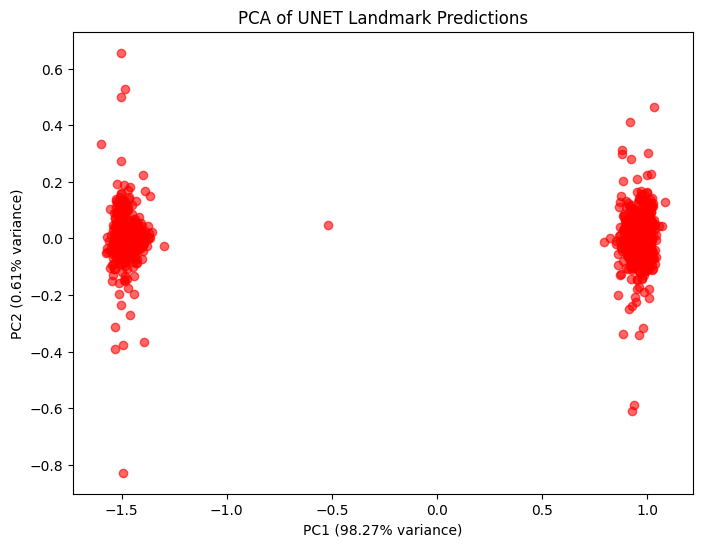

In [45]:
# PCA
X = UNET_full_augmenatation.reshape(UNET_full_augmenatation.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# get variance
var_ratio = pca.explained_variance_ratio_
pc1_var = var_ratio[0] * 100
pc2_var = var_ratio[1] * 100

# plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c="red", alpha=0.6)

plt.xlabel(f"PC1 ({pc1_var:.2f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.2f}% variance)")
plt.title("PCA of UNET Landmark Predictions")
plt.show()

UNet LDA Cross Validation accuracys (Genera and Species (all/ >20))

In [46]:
# flat array
X_UNet = UNET_full_augmenatation.reshape(UNET_full_augmenatation.shape[0], -1)
y_genera = y_test_genera

lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_UNet, y_genera, cv=cv)

print(f"LDA Cross-Validation Accuracy UNet Genera: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy UNet Genera: 0.794 ± 0.013


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [47]:
# count genera
genera_counts = Counter(y_test_genera)

# only >=20
valid_genera = [s for s, count in genera_counts.items() if count >= 20]
mask = np.isin(y_test_genera, valid_genera)

X_filtered = X_UNet[mask]
y_filtered = np.array(y_test_genera)[mask]

# LDA cross validation
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_filtered, y_filtered, cv=cv)

print(f"LDA Cross-Validation Accuracy UNet Genera (>=20 samples): {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy UNet Genera (>=20 samples): 0.814 ± 0.011


In [49]:
# flat array
X_UNet = UNET_full_augmenatation.reshape(UNET_full_augmenatation.shape[0], -1)
y_species = y_test_species

lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_UNet, y_species, cv=cv)

print(f"LDA Cross-Validation Accuracy UNet Species: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy UNet Species: 0.621 ± 0.011


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [48]:
# count species
species_counts = Counter(y_test_species)

# only >=20
valid_species = [s for s, count in species_counts.items() if count >= 20]
mask = np.isin(y_test_species, valid_species)

X_filtered = X_UNet[mask]
y_filtered = np.array(y_test_species)[mask]

# LDA with cross validation
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_filtered, y_filtered, cv=cv)

print(f"LDA Cross-Validation Accuracy UNet Species (>=20 samples): {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy UNet Species (>=20 samples): 0.661 ± 0.022


plot LDA UNet

LDA Cross-Validation Accuracy: 0.661 ± 0.022


/tmp/ipython-input-87022249.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(le.classes_))


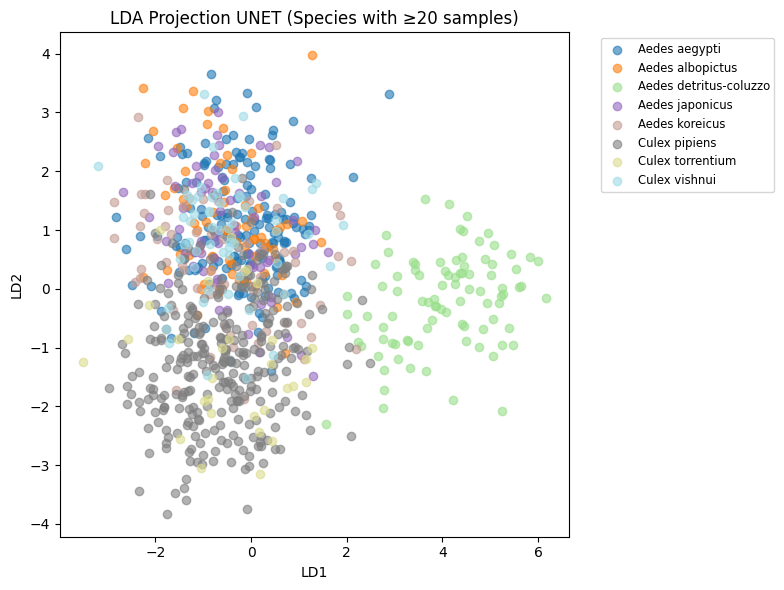

In [50]:
#only species >20
species_counts = Counter(y_test_species)
valid_species = [s for s, count in species_counts.items() if count >= 20]

mask = np.isin(y_test_species, valid_species)
X_filtered = X_UNet[mask]
y_filtered = np.array(y_test_species)[mask]

# LDA cross validation
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_filtered, y_filtered, cv=cv)

print(f"LDA Cross-Validation Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# 2D
lda_2d = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda_2d.fit_transform(X_filtered, y_filtered)

# color
le = LabelEncoder()
y_num = le.fit_transform(y_filtered)
colors = plt.cm.get_cmap("tab20", len(le.classes_))

plt.figure(figsize=(8,6))
for i, species in enumerate(le.classes_):
    plt.scatter(
        X_lda[y_num == i, 0],
        X_lda[y_num == i, 1],
        label=species,
        alpha=0.6,
        color=colors(i))

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA Projection UNET (Species with ≥20 samples)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

CNN LDA Cross Validation accuracys (Genera and Species (all/ >20))

In [51]:
# flat array
X_CNN = CNN_full_augmentation.reshape(CNN_full_augmentation.shape[0], -1)
y_genera = y_test_genera

lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_CNN, y_genera, cv=cv)

print(f"LDA Cross-Validation Accuracy CNN Genera: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy CNN Genera: 0.518 ± 0.025


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [52]:
# only >=20
valid_genera = [s for s, count in genera_counts.items() if count >= 20]
mask = np.isin(y_test_genera, valid_genera)

X_filtered = X_CNN[mask]
y_filtered = np.array(y_test_genera)[mask]

# LDA cross-validation
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_filtered, y_filtered, cv=cv)

print(f"LDA Cross-Validation Accuracy CNN Genera (>=20 samples): {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy CNN Genera (>=20 samples): 0.574 ± 0.023


In [53]:
# flat array
X_CNN = CNN_full_augmentation.reshape(CNN_full_augmentation.shape[0], -1)
y_species = y_test_species

#LDA
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_CNN, y_species, cv=cv)

print(f"LDA Cross-Validation Accuracy CNN Species: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy CNN Species: 0.299 ± 0.012


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [54]:
# only >=20 Samples
valid_species = [s for s, count in species_counts.items() if count >= 20]
mask = np.isin(y_test_species, valid_species)

X_filtered = X_CNN[mask]
y_filtered = np.array(y_test_species)[mask]

# LDA cross-validation
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_filtered, y_filtered, cv=cv)

print(f"LDA Cross-Validation Accuracy CNN Species (>=20 samples): {np.mean(scores):.3f} ± {np.std(scores):.3f}")

LDA Cross-Validation Accuracy CNN Species (>=20 samples): 0.422 ± 0.041


plot CNN LDA species

LDA Cross-Validation Accuracy: 0.422 ± 0.041


/tmp/ipython-input-1889676341.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(le.classes_))


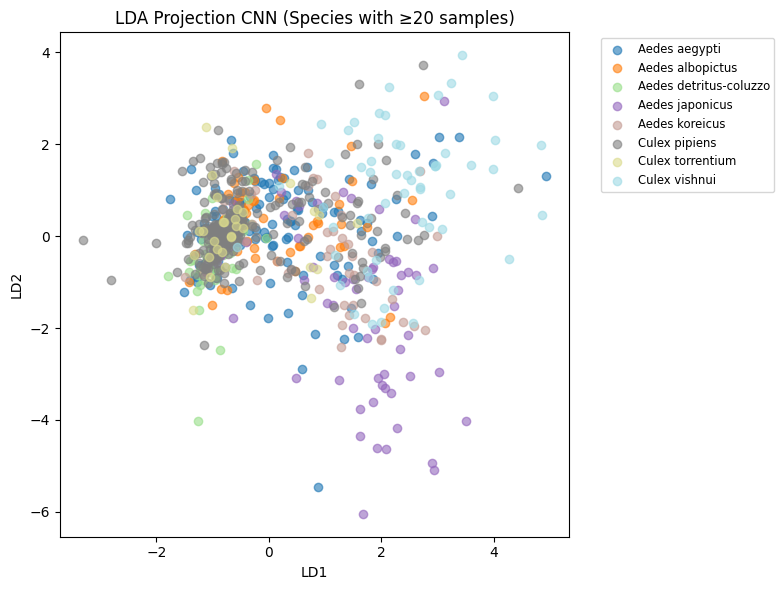

In [55]:
species_counts = Counter(y_test_species)
valid_species = [s for s, count in species_counts.items() if count >= 20]

mask = np.isin(y_test_species, valid_species)
X_filtered = X_CNN[mask]
y_filtered = np.array(y_test_species)[mask]

# LDA
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_filtered, y_filtered, cv=cv)

print(f"LDA Cross-Validation Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# 2D
lda_2d = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda_2d.fit_transform(X_filtered, y_filtered)

# color
le = LabelEncoder()
y_num = le.fit_transform(y_filtered)
colors = plt.cm.get_cmap("tab20", len(le.classes_))

plt.figure(figsize=(8,6))
for i, species in enumerate(le.classes_):
    plt.scatter(
        X_lda[y_num == i, 0],
        X_lda[y_num == i, 1],
        label=species,
        alpha=0.6,
        color=colors(i))

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA Projection CNN (Species with ≥20 samples)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

plot CNN LDA Genera

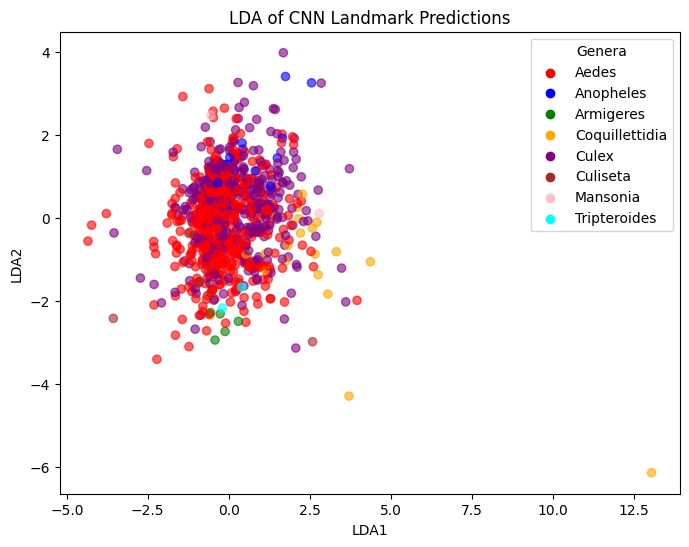

In [59]:
# X: (n_samples, n_landmarks*2), y: genera labels
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda_CNN = lda.fit_transform(X_CNN, y_genera)

# Farben
colors_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']

color_dict = {genus: colors_list[i] for i, genus in enumerate(np.unique(y_genera))}
point_colors = [color_dict[genus] for genus in y_genera]

# Scatterplot
plt.figure(figsize=(8,6))
plt.scatter(X_lda_CNN[:,0], X_lda_CNN[:,1], c=point_colors, alpha=0.6)

# Legende
for genus, color in color_dict.items():
    plt.scatter([], [], color=color, label=genus)
plt.legend(title="Genera")

plt.xlabel("LDA1")
plt.ylabel("LDA2")
plt.title("LDA of CNN Landmark Predictions")
plt.show()

plot UNet LDA Genera

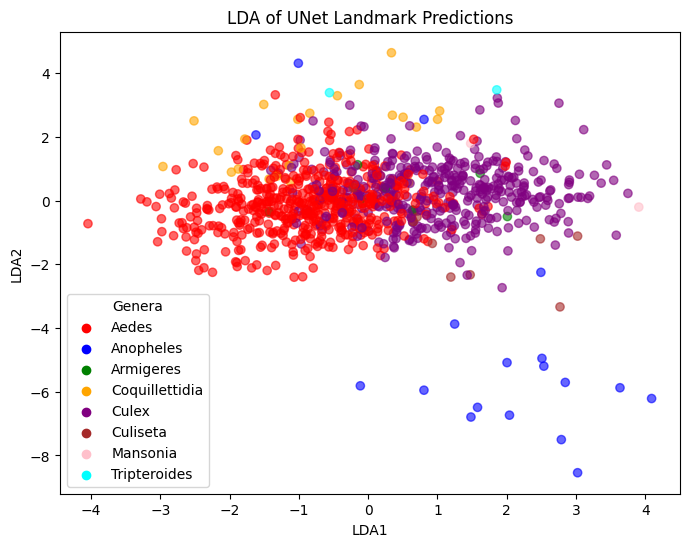

In [61]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda_UNET = lda.fit_transform(X_UNet, y_genera)

# color
colors_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']
color_dict = {genus: colors_list[i] for i, genus in enumerate(np.unique(y_genera))}
point_colors = [color_dict[genus] for genus in y_genera]

# plot
plt.figure(figsize=(8,6))
plt.scatter(X_lda_UNET[:,0], X_lda_UNET[:,1], c=point_colors, alpha=0.6)

# legend
for genus, color in color_dict.items():
    plt.scatter([], [], color=color, label=genus)
plt.legend(title="Genera")

plt.xlabel("LDA1")
plt.ylabel("LDA2")
plt.title("LDA of UNet Landmark Predictions")
plt.show()

PCA for culex pipiens

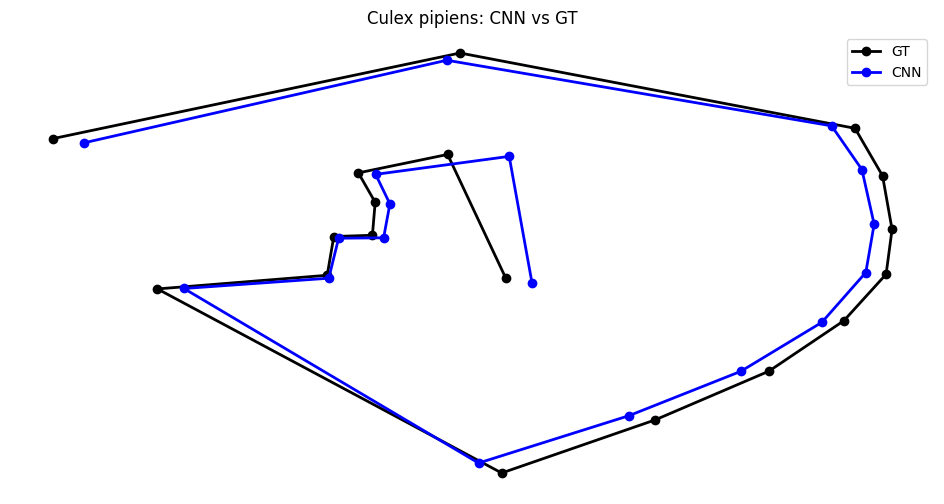

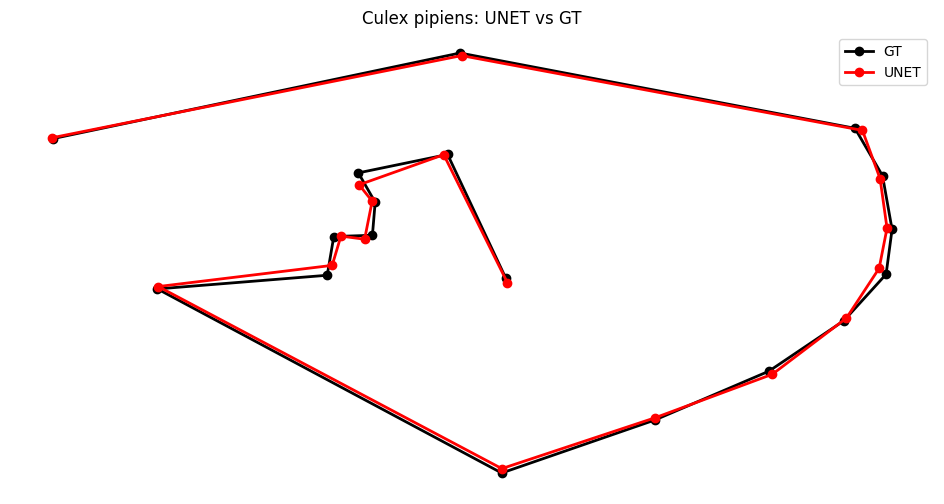

In [62]:
# only Culex pipiens
species_mask = df_iphone.loc[idx_test, 'LABEL'] == 'Culex pipiens'
selected_indices = np.where(species_mask)[0]   # Index im Original-Array

# true vs predicted for Culex pipiens
true_species = true_landmarks[selected_indices]
CNN_species = CNN_full_augmentation[selected_indices]
UNET_species = UNET_full_augmenatation[selected_indices]

# procrustes alignment
def procrustes_pixel(true_lms, pred_lms):
    true_centered = true_lms - np.mean(true_lms, axis=0)
    pred_centered = pred_lms - np.mean(pred_lms, axis=0)
    U, _, Vt = np.linalg.svd(pred_centered.T @ true_centered)
    R = U @ Vt
    pred_aligned = pred_centered @ R
    pred_aligned += np.mean(true_lms, axis=0)
    return pred_aligned

mean_GT = np.mean(true_species, axis=0)
mean_CNN = np.mean([procrustes_pixel(true_species[i], CNN_species[i]) for i in range(true_species.shape[0])], axis=0)
mean_UNET = np.mean([procrustes_pixel(true_species[i], UNET_species[i]) for i in range(true_species.shape[0])], axis=0)

# axes
padding_x = 0.05 * (mean_GT[:,0].max() - mean_GT[:,0].min())
padding_y = 0.05 * (mean_GT[:,1].max() - mean_GT[:,1].min())
x_min = min(mean_GT[:,0].min(), mean_CNN[:,0].min(), mean_UNET[:,0].min()) - padding_x
x_max = max(mean_GT[:,0].max(), mean_CNN[:,0].max(), mean_UNET[:,0].max()) + padding_x
y_min = min(mean_GT[:,1].min(), mean_CNN[:,1].min(), mean_UNET[:,1].min()) - padding_y
y_max = max(mean_GT[:,1].max(), mean_CNN[:,1].max(), mean_UNET[:,1].max()) + padding_y

# plot CNN vs GT
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mean_GT[:,0], mean_GT[:,1], '-o', color='black', lw=2, label='GT', markersize=6)
ax.plot(mean_CNN[:,0], mean_CNN[:,1], '-o', color='blue', lw=2, label='CNN', markersize=6)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.invert_yaxis()
ax.set_aspect((x_max - x_min) / ((y_max - y_min)*2))
ax.axis('off')
ax.legend()
plt.title('Culex pipiens: CNN vs GT')
plt.show()

# plot UNet vs GT
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mean_GT[:,0], mean_GT[:,1], '-o', color='black', lw=2, label='GT', markersize=6)
ax.plot(mean_UNET[:,0], mean_UNET[:,1], '-o', color='red', lw=2, label='UNET', markersize=6)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.invert_yaxis()
ax.set_aspect((x_max - x_min) / ((y_max - y_min)*2))
ax.axis('off')
ax.legend()
plt.title('Culex pipiens: UNET vs GT')
plt.show()

In [63]:
# error per landmark
errors_CNN = np.sqrt(np.sum((true_species - CNN_species)**2, axis=2))  # Shape: (n_samples, n_landmarks)
errors_UNET = np.sqrt(np.sum((true_species - UNET_species)**2, axis=2))

# mean error per landmark
mean_error_CNN = errors_CNN.mean(axis=0)   # Länge = n_landmarks
mean_error_UNET = errors_UNET.mean(axis=0)

# find best/ worst
best_lmk_idx_CNN = np.argmin(mean_error_CNN) + 1  # +1 for name based
worst_lmk_idx_CNN = np.argmax(mean_error_CNN) + 1
best_lmk_idx_UNET = np.argmin(mean_error_UNET) + 1
worst_lmk_idx_UNET = np.argmax(mean_error_UNET) + 1

print(f"CNN: Best Landmark: {best_lmk_idx_CNN} (Mean Error = {mean_error_CNN[best_lmk_idx_CNN-1]:.2f})")
print(f"CNN: Worst Landmark: {worst_lmk_idx_CNN} (Mean Error = {mean_error_CNN[worst_lmk_idx_CNN-1]:.2f})")

print(f"UNET: Best Landmarke: {best_lmk_idx_UNET} (Mean Error = {mean_error_UNET[best_lmk_idx_UNET-1]:.2f})")
print(f"UNET: Worst Landmark: {worst_lmk_idx_UNET} (Mean Error = {mean_error_UNET[worst_lmk_idx_UNET-1]:.2f})")

CNN: Best Landmark: 5 (Mean Error = 0.02)
CNN: Worst Landmark: 17 (Mean Error = 0.05)
UNET: Best Landmarke: 11 (Mean Error = 0.01)
UNET: Worst Landmark: 16 (Mean Error = 0.02)
